### Import Required Packages and datasets

In [726]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [727]:
df = pd.read_csv("/home/nsl53/Desktop/NSL_Training/MachineLearning/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.customerID.nunique())

7043


### EDA of data

In [728]:

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##### The customerID column seems to be some type of primary key for relational mapping and is of no use in the dataset, so lets drop it 

In [729]:
df.drop(axis=1,labels='customerID',inplace=True)
df_col=df.copy(deep=True)

In [730]:
df.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

### Categorizing Columns according to statistical datatype 

In [731]:
bincols=list(df.nunique()[df.nunique()==2].index)
numcols=list(df.nunique()[df.nunique()>10].index)
catcols=df.columns[~df.columns.isin(numcols+bincols)]
print(f"From here we can see that we have:\n  {len(numcols)} numerical columns,\n  {len(bincols)} binary columns,\n  {len(catcols)} categorical columns.")

From here we can see that we have:
  3 numerical columns,
  7 binary columns,
  10 categorical columns.


In [732]:
print("Dtypes in numcols:")
print({i:df[i].dtype for i in numcols})
print("Dtypes in bincols:")
print({i:df[i].dtype for i in bincols})
print("Dtypes in catcols:")
print({i:df[i].dtype for i in catcols})

Dtypes in numcols:
{'tenure': dtype('int64'), 'MonthlyCharges': dtype('float64'), 'TotalCharges': dtype('O')}
Dtypes in bincols:
{'gender': dtype('O'), 'SeniorCitizen': dtype('int64'), 'Partner': dtype('O'), 'Dependents': dtype('O'), 'PhoneService': dtype('O'), 'PaperlessBilling': dtype('O'), 'Churn': dtype('O')}
Dtypes in catcols:
{'MultipleLines': dtype('O'), 'InternetService': dtype('O'), 'OnlineSecurity': dtype('O'), 'OnlineBackup': dtype('O'), 'DeviceProtection': dtype('O'), 'TechSupport': dtype('O'), 'StreamingTV': dtype('O'), 'StreamingMovies': dtype('O'), 'Contract': dtype('O'), 'PaymentMethod': dtype('O')}


##### As we can see that there seems to be discripency in one data type, specifically "TotalCharges", so we need to fix this. As for SeniorCitizens, binary data is often represented as integers (0,1).   

###  Feature Engineering, Cleaning and Scaling of Numerical Columns

<AxesSubplot:>

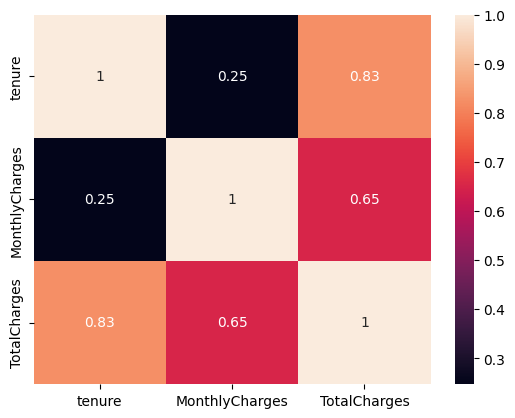

In [733]:
feature_corr=df[numcols][df.TotalCharges.str.match(r"\d+")]
feature_corr['TotalCharges']=feature_corr.TotalCharges.astype('float64')
sns.heatmap(feature_corr.corr(),annot=True)

##### As we can see there is high colinearity between TotalCharges and the other two columns, we can drop TotalCharges and make a new column that combines the other two columns

<AxesSubplot:ylabel='Density'>

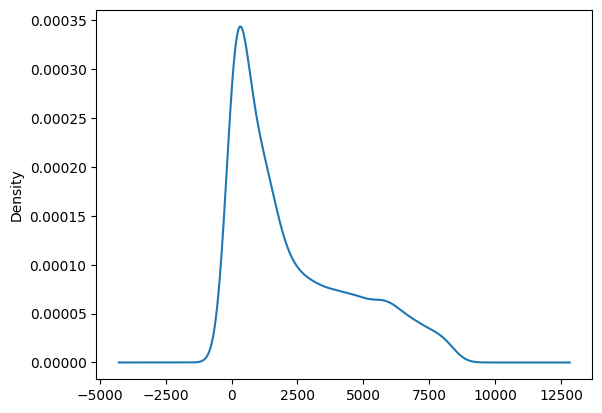

In [734]:
df["numerical"]=df.tenure*df.MonthlyCharges
df.drop(axis=1,labels=['TotalCharges','MonthlyCharges','tenure'],inplace=True)
df["numerical"].plot.kde()

##### As we can see that there is some skewness to our numerical column, lets see if we have any outliers

In [735]:
q_=df['numerical'].quantile([0.25,0.75]).to_list()
out_range=1.5*(q_[1]-q_[0])
print(f"Number of outliers in numerical: {df[~df['numerical'].between(*[q_[0]-out_range,q_[1]+out_range])].size}")
print("As we can see no presence of outliers, we shall use StandardScaler for better performance on outliers")


Number of outliers in numerical: 0
As we can see no presence of outliers, we shall use StandardScaler for better performance on outliers


In [736]:
sscale=StandardScaler()
df['numerical']=sscale.fit_transform(df['numerical'].to_numpy().reshape(-1,1))

## Branching into different methods for encoding categorical (and ordinal) data
### Method 1: Ordinal encoding for ordinal feature subset within categorical feature set
#### Cleaning and Binarizing Binary Columns

In [737]:
df['SeniorCitizen']=df['SeniorCitizen'].astype('O')

In [738]:
for i in bincols:
    df[i]=df[i].apply(lambda x: 1  if x=='Yes' or x=='Male' else 0)

#### Cleaning and Engineering Ordinal Columns

In [739]:
for i in catcols:
    print(i)
    print(df[i].unique())

MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


##### From here we can see that all columns with both 'Yes' and 'No' as unique values can be represented as ordinal data, also, 'Contract' and 'InternetService' follows an ordinal structure.Now, lets keep two datasets, one with ordinal representation of available ordinal features among all the categorical features and one with one hot encoding of all the categorical features

In [740]:
catcols_=catcols
print(catcols_)
ordcols=[i for i in catcols if "Payment" not in i]
print(ordcols)
catcols=['PaymentMethod']

Index(['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaymentMethod'],
      dtype='object')
['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract']


In [741]:
df.head(20)

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,numerical
0,0,0,1,0,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,0,-0.993448
1,1,0,0,0,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,0,-0.151588
2,1,0,0,0,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,1,-0.959071
3,1,0,0,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),0,-0.166072
4,0,0,0,0,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,1,-0.944189
5,0,0,0,0,1,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,1,Electronic check,1,-0.654598
6,1,0,0,1,1,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,1,Credit card (automatic),0,-0.141034
7,0,0,0,0,0,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,0,Mailed check,0,-0.875258
8,0,0,1,0,1,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,1,Electronic check,1,0.289158
9,1,0,0,1,1,No,DSL,Yes,Yes,No,No,No,No,One year,0,Bank transfer (automatic),0,0.530661


In [742]:
def to_ord(x):
    if (x=='Yes') | (x=='Two year') | (x=='Fiber optic'):
        return 2
    elif (x=='No') | (x=='One year') | (x=='DSL'):
        return 1
    else:
        return 0
df_=df.__deepcopy__()
for i in ordcols:
    df[i]=df[i].apply(lambda x:to_ord(x))

#### Scaling ordinal data

In [743]:
mnmx_scale=MinMaxScaler()
df[ordcols]=mnmx_scale.fit_transform(df[ordcols].to_numpy().reshape(-1,len(ordcols)))


In [744]:
cathot=pd.get_dummies(df[catcols])
df.drop(labels=catcols,axis=1,inplace=True)

In [745]:
df=pd.concat([df,cathot],axis=1)
y=df['Churn'].to_numpy().reshape(-1,1)
x=df.drop(labels="Churn",axis=1).to_numpy()

### Training Logistic Regression Model on features engineered according to Method 1

In [746]:
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.3,random_state=123)
log_reg=LogisticRegression()

In [747]:
for i in df.columns:
    print(f"{i}:{df[i].dtype}")

gender:int64
SeniorCitizen:int64
Partner:int64
Dependents:int64
PhoneService:int64
MultipleLines:float64
InternetService:float64
OnlineSecurity:float64
OnlineBackup:float64
DeviceProtection:float64
TechSupport:float64
StreamingTV:float64
StreamingMovies:float64
Contract:float64
PaperlessBilling:int64
Churn:int64
numerical:float64
PaymentMethod_Bank transfer (automatic):uint8
PaymentMethod_Credit card (automatic):uint8
PaymentMethod_Electronic check:uint8
PaymentMethod_Mailed check:uint8


In [748]:
param_grid=[
    {'penalty':['l1','l2','elasticnet','none',],
    'C':np.logspace(-4,4,10),
    'solver':["lbfgs",'newton-cg','liblinear','sag','saga'],
    'max_iter':[100,500,1000,2500,5000,10000]
    }
]

clf=GridSearchCV(log_reg,param_grid=param_grid,cv=4,verbose=False,n_jobs=-1,refit=True)
clf.fit(x,y)
log_reg=clf.best_estimator_

print(f'According to Grid Search, our best set of parameters and its associated validation score:\n\tParams:{clf.best_params_}\n\tVal_Score:{clf.score}')


log_reg.fit(x,y)
pred=log_reg.predict(x)
from sklearn.metrics import classification_report
print(classification_report(pred,y))


/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when 

According to Grid Search, our best set of parameters and its associated validation score:
	Params:{'C': 0.046415888336127774, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
	Val_Score:<bound method BaseSearchCV.score of GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                          'max_iter': [100, 500, 1000, 2500, 5000, 10000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}],
             verbose=False)>
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5580
           1       0.52      0.66      0.58      1463

    accuracy              

/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2160 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/linear_m

### Evaluating our model trained according to Method 1

In [749]:
log_reg.fit(x,y)
pred=log_reg.predict(x)
from sklearn.metrics import classification_report
print(classification_report(pred,y))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5580
           1       0.52      0.66      0.58      1463

    accuracy                           0.80      7043
   macro avg       0.71      0.75      0.73      7043
weighted avg       0.82      0.80      0.81      7043



/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Method 2: One Hot Encoding for whole Categorical Set

In [750]:

y_one=df_col["Churn"].to_numpy().reshape(-1,1)
print(len(catcols_),len(bincols))
catcols_=list(catcols_)+list(bincols)
dummy=df_col[catcols_]
cat_df=pd.get_dummies(dummy)



10 7


In [751]:
cat_df.columns.size

44

#### Cleaning and Scaling Numerical Columns

In [752]:
num_df=df_col[numcols]
num_df['TotalCharges'][num_df.TotalCharges==' ']='0'
num_df=num_df.astype('float64')
num_df=pd.DataFrame(sscale.fit_transform(num_df),columns=numcols)


/tmp/ipykernel_35920/1610645087.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_df['TotalCharges'][num_df.TotalCharges==' ']='0'


#### One Hot Encoding of all categorical data

In [753]:
df_col.drop(axis=1,labels=catcols_,inplace=True)
df_col.drop(axis=1,labels=numcols,inplace=True)
df_col=pd.concat([df_col,cat_df,num_df],axis=1)
x_one=df_col.to_numpy()


### Training Logistic Regression Model on features engineered according to Method 2

In [754]:
param_grid=[
    {'penalty':['l1','l2','elasticnet','none',],
    'C':np.logspace(-4,4,10),
    'solver':["lbfgs",'newton-cg','liblinear','sag','saga'],
    'max_iter':[100,500,1000,2500,5000]
    }
]
log_reg_one=LogisticRegression()
clf_one=GridSearchCV(log_reg_one,param_grid=param_grid,cv=4,verbose=False,n_jobs=-1,refit=True)
clf_one.fit(x_one,y)
log_reg=clf.best_estimator_














/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when 

### Evaluating our model trained according to Method 1

In [755]:
log_reg_one.fit(x_one,y)
pred=log_reg_one.predict(x_one)
from sklearn.metrics import classification_report
print(log_reg_one.score(x_one,y))
print(classification_report(pred,y))

1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5174
           1       1.00      1.00      1.00      1869

    accuracy                           1.00      7043
   macro avg       1.00      1.00      1.00      7043
weighted avg       1.00      1.00      1.00      7043



/home/nsl53/anaconda3/envs/eda_/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [756]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(pred,y))

[[5174    0]
 [   0 1869]]


#### As we can see that our first approach was a better and more accurate approach as the model was able to generalize better than model made with approach 2. However, more data points and inference is needed in order to make sure that model according to Method 2 in fact did overfit as the confusion matrix indicates.